# Hospital ward dynamic contact network
Lien vers l'article: http://www.sociopatterns.org/datasets/hospital-ward-dynamic-contact-network/

Le notebook est divisé en plusieurs parties afin d’analyser de manière structurée les graphes de contacts hospitaliers et de couvrir les principaux concepts.

1. Contexte des données
2. Représentation des graphes
3. Propriétés statistiques des réseaux (analyse descriptive)
4. Centralités
5. Communautés et modularité
6. Graphes pondérés et temporels
7. Random walks, diffusion
8. Modèles de graphes

Le choix des concepts est justifié et discuté dans le rapport écrit.

In [16]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import networkx as nx
# uv add python-louvain
import community as community_louvain
import igraph as ig
from collections import Counter

## 1. Contexte des données

In [2]:
df = pd.read_csv("./data/detailed_list_of_contacts_Hospital.dat", delimiter="\t", header=None)

df.columns = ["time", "id_1", "id_2", "role_1", "role_2"]

## 2. Représentation des graphes
Agrégation temporelle des données pour obtenir un graphe statique qui résume l’ensemble des interactions observées

In [3]:
# c.f. sylla IV. A. Definitions
# Colonne qui représente une arête non orientée
edges = df[["id_1", "id_2"]].copy()

# Ordonner les paire, (i, j) = (j, i)
edges["u"] = edges.min(axis=1)
edges["v"] = edges.max(axis=1)

# Garder les relations uniques, sans la répétition ou le temps
edges_unique = edges[["u", "v"]].drop_duplicates()

edges_unique.head(), len(edges_unique)

(      u     v
 0  1157  1232
 1  1157  1191
 2  1157  1159
 4  1159  1191
 9  1144  1159,
 1139)

In [4]:
# Graphe non orienté agrégé (non pondéré)
G = nx.Graph()
G.add_edges_from(edges_unique[["u", "v"]].itertuples(index=False, name=None))

# Vérifications de base
print("Nb de noeuds:", G.number_of_nodes())
print("Nb d'arêtes:", G.number_of_edges())
all_ids = pd.unique(df[["id_1", "id_2"]].values.ravel())
print("Nb d'IDs dans les données:", len(all_ids))

Nb de noeuds: 75
Nb d'arêtes: 1139
Nb d'IDs dans les données: 75


In [5]:
# mapping ID et rôle
roles_1 = df[["id_1", "role_1"]].rename(columns={"id_1": "id", "role_1": "role"})
roles_2 = df[["id_2", "role_2"]].rename(columns={"id_2": "id", "role_2": "role"})

roles = pd.concat([roles_1, roles_2]).drop_duplicates()
role_dict = dict(zip(roles["id"], roles["role"]))

# Ajout des rôles comme attributs de noeuds
nx.set_node_attributes(G, role_dict, name="role")

# Vérifier quelques noeuds
list(G.nodes(data=True))[:5]

[(1157, {'role': 'MED'}),
 (1232, {'role': 'ADM'}),
 (1191, {'role': 'MED'}),
 (1159, {'role': 'MED'}),
 (1144, {'role': 'MED'})]

## 3. Propriétés statistiques des réseaux (analyse descriptive)

In [6]:
# Taille, densité, connectivité (cellule)
N = G.number_of_nodes()
M = G.number_of_edges()

density = nx.density(G)

# Composantes connexes
components = list(nx.connected_components(G))
n_components = len(components)
gcc_size = len(max(components, key=len))  # giant connected component

print("N (noeuds) =", N)
print("M (arêtes) =", M)
print("Densité =", density)
print("Nombre de composantes connexes =", n_components)
print("Taille de la composante géante =", gcc_size, f"({gcc_size/N:.1%} des noeuds)")

# le réseau est-il majoritairement connecté ?
# densité faible, réseau clairsemé

N (noeuds) = 75
M (arêtes) = 1139
Densité = 0.4104504504504505
Nombre de composantes connexes = 1
Taille de la composante géante = 75 (100.0% des noeuds)


Degré moyen = 30.373333333333335
Degré médian = 27.0
Degré max = 61


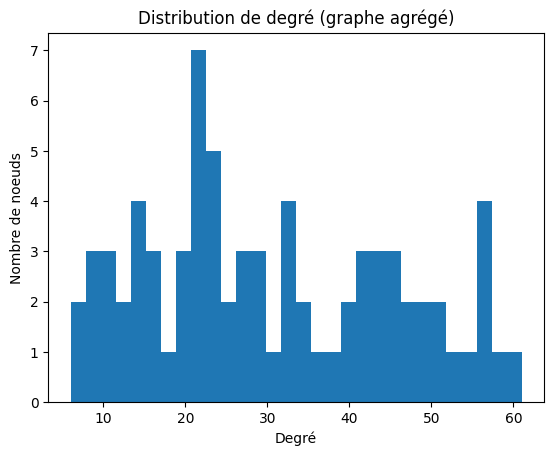

In [7]:
# Distribution de degré (cellule)
# c.f. sylla IV. B. Degree distribution
degrees = np.array([d for _, d in G.degree()])

print("Degré moyen =", degrees.mean())
print("Degré médian =", np.median(degrees))
print("Degré max =", degrees.max())

plt.figure()
plt.hist(degrees, bins=30)
plt.xlabel("Degré")
plt.ylabel("Nombre de noeuds")
plt.title("Distribution de degré (graphe agrégé)")
plt.show()


In [8]:
# Clustering
clustering_local = nx.clustering(G)
avg_clustering = np.mean(list(clustering_local.values()))

transitivity = nx.transitivity(G)  # clustering global (triangles/triades)

print("Clustering moyen (moyenne locale) =", avg_clustering)
print("Transitivity (clustering global) =", transitivity)


Clustering moyen (moyenne locale) = 0.6402796539914467
Transitivity (clustering global) = 0.5880037219955623


In [9]:
# Comparaison à un null model c.f. sylla p. 21 et 24
# Séquence de degrés du graphe observé
degree_sequence = [d for _, d in G.degree()]

# Génération du configuration model
G_conf = nx.configuration_model(degree_sequence)

# Conversion en graphe simple (suppression multi-arêtes et boucles)
G_conf_simple = nx.Graph(G_conf)
G_conf_simple.remove_edges_from(nx.selfloop_edges(G_conf_simple))


In [10]:
# Clustering du graphe observé
clust_obs = nx.average_clustering(G)

# Clustering du null model
clust_conf = nx.average_clustering(G_conf_simple)

print("Clustering moyen (observé) =", clust_obs)
print("Clustering moyen (null model) =", clust_conf)


Clustering moyen (observé) = 0.6402796539914468
Clustering moyen (null model) = 0.40643277818440465


## 4. Centralités

In [11]:
# Centralité de degrés c.f. sylla IV. E.
degree_centrality = dict(G.degree())

# Top 10 des noeuds par degré
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_degree

[(1098, 61),
 (1193, 58),
 (1115, 57),
 (1164, 57),
 (1295, 56),
 (1210, 56),
 (1109, 55),
 (1157, 53),
 (1658, 51),
 (1144, 50)]

In [12]:
# betweenness centrality
betweenness = nx.betweenness_centrality(G, normalized=True)

top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness

[(1098, 0.040408304449621735),
 (1193, 0.03515642027965047),
 (1164, 0.03126633321619274),
 (1115, 0.028688877674588612),
 (1109, 0.027834568483203603),
 (1295, 0.02682764175660108),
 (1210, 0.02644993182527258),
 (1658, 0.022657108475668104),
 (1190, 0.02216525800306036),
 (1157, 0.02165150384471469)]

In [13]:
# closeness centrality
closeness = nx.closeness_centrality(G)

top_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]
top_closeness

[(1098, 0.8505747126436781),
 (1193, 0.8222222222222222),
 (1115, 0.8131868131868132),
 (1164, 0.8131868131868132),
 (1295, 0.8043478260869565),
 (1210, 0.8043478260869565),
 (1109, 0.7956989247311828),
 (1157, 0.7789473684210526),
 (1658, 0.7628865979381443),
 (1144, 0.7551020408163265)]

## 5. Communautés et modularité

In [14]:
# Détection de communautés avec Louvain
partition = community_louvain.best_partition(G)

# Nombre de communautés
n_communities = len(set(partition.values()))
print("Nombre de communautés détectées :", n_communities)

Nombre de communautés détectées : 4


In [15]:
# Ajouter les communautés comme attributs de noeuds
nx.set_node_attributes(G, partition, name="community")

In [17]:
# Taille des communautés
community_sizes = Counter(partition.values())
community_sizes

Counter({0: 27, 2: 17, 1: 17, 3: 14})

In [18]:
# Est-ce que les communautés correspondent aux rôles des individus
data_comm_role = [
    (node, G.nodes[node]["role"], G.nodes[node]["community"])
    for node in G.nodes()
]

df_comm = pd.DataFrame(data_comm_role, columns=["id", "role", "community"])

pd.crosstab(df_comm["community"], df_comm["role"])

role,ADM,MED,NUR,PAT
community,,,,
0,7,10,3,7
1,0,0,10,7
2,1,1,7,8
3,0,0,7,7


In [ ]:
# Robustesse des communautés (stabilité des partitions)
partitions = [community_louvain.best_partition(G) for _ in range(5)]
[len(set(p.values())) for p in partitions]

[5, 5, 4, 4, 4]

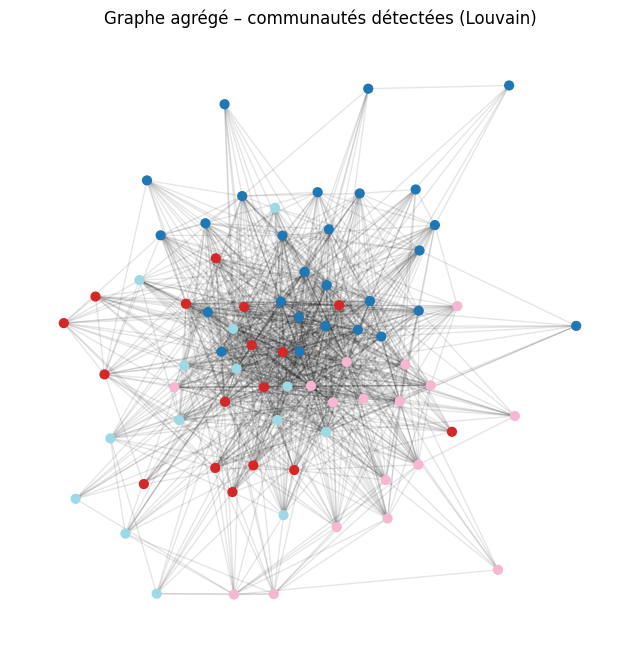

In [20]:
# Position des noeuds (layout)
pos = nx.spring_layout(G, seed=42)
# Récupérer les communautés
communities = nx.get_node_attributes(G, "community")

# Liste des communautés uniques
unique_comms = sorted(set(communities.values()))

# Assigner une couleur à chaque communauté
color_map = {c: i for i, c in enumerate(unique_comms)}
node_colors = [color_map[communities[n]] for n in G.nodes()]
plt.figure(figsize=(8, 8))

nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    node_size=40,
    cmap=plt.cm.tab20
)

nx.draw_networkx_edges(
    G, pos,
    alpha=0.1
)

plt.title("Graphe agrégé – communautés détectées (Louvain)")
plt.axis("off")
plt.show()

## 6. Graphes pondérés et temporels

In [21]:
# Création des paires non orientées
df["u"] = df[["id_1", "id_2"]].min(axis=1)
df["v"] = df[["id_1", "id_2"]].max(axis=1)

# Nombre de contacts par paire
edge_weights = (
    df.groupby(["u", "v"])
      .size()
      .reset_index(name="n_contacts")
)

edge_weights.head()

,u,v,n_contacts
0,1098,1100,1
1,1098,1105,3
2,1098,1108,3
3,1098,1109,27
4,1098,1114,27


In [22]:
G_weighted = nx.Graph()

for _, row in edge_weights.iterrows():
    G_weighted.add_edge(row["u"], row["v"], weight=row["n_contacts"])

# Vérification
list(G_weighted.edges(data=True))[:5]


[(np.int64(1098), np.int64(1100), {'weight': np.int64(1)}),
 (np.int64(1098), np.int64(1105), {'weight': np.int64(3)}),
 (np.int64(1098), np.int64(1108), {'weight': np.int64(3)}),
 (np.int64(1098), np.int64(1109), {'weight': np.int64(27)}),
 (np.int64(1098), np.int64(1114), {'weight': np.int64(27)})]

In [ ]:
# Comparer degrés et strength
strength = dict(G_weighted.degree(weight="weight"))

# Comparaison pour quelques noeuds
comparison = pd.DataFrame({
    "degree": dict(G.degree()),
    "strength": strength
})

comparison.sort_values("strength", ascending=False).head()
# Un individu peut-il avoir peu de voisins mais beaucoup de contacts ? Oui, super spreader


,degree,strength
1115,57,4286
1210,56,4077
1295,56,3695
1207,49,3130
1157,53,2849
